In [1]:
import numpy as np
import scipy
from scipy import signal
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def get_gaussian_kernel(size, sigma):
  """
  This function returns a gaussian kernel given size and sigma

  size - number of rows/ no. of cols 
  sigma - standard deviation of the gaussian kernel required
  returns size * size 
  """
  # DO NOT MODIFY
  kernel = np.fromfunction(lambda x, y: (1/(2*np.pi*sigma**2)) * np.e ** ((-1*((x-(size-1)/2)**2+(y-(size-1)/2)**2))/(2*sigma**2)), (size, size))
  kernel /= np.sum(kernel)
  
  return kernel

In [3]:
def expand(input_image):
    """
    This function returns The image after the expand operation

    Input: 
    input_image: (m x n x 1)/(m x n x 3)  - The input image (numpy array)

    Output-
    output - (2m x 2n x 1)/(2m x 2n x 3)  - The output image (numpy array)

    """

    # 1) Create the expanded image. 
    #    The new image should be twice the size of the original image.
    #    So, for an n x n image you will create an empty 2n x 2n image
    #    Fill every second row and column with the rows and columns of the original
    #    image
    #    i.e., 1st row of I -> 1st row of expanded image
    #          2nd row of I -> 3rd row of expanded image
    #          3rd row of I -> 5th row of expanded image, and so on

    img = np.zeros((2 * input_image.shape[0], 2 * input_image.shape[1], input_image.shape[2]))
    for i in range(3):
      img[::2, ::2, i] = input_image[:,:,i]
    # IMPLEMENT THIS FUNCTION HERE

    # 2) Create a Gaussian kernel of size 5x5 and standard deviation equal to 1 

    kernel = get_gaussian_kernel(5,1)
    # 3) Convolve the input image with the filter kernel 
    output = signal.convolve(img, kernel[:, :, None], mode='same')

    return output*4

In [4]:
def reduce(input_image):
    
  """
  This funcion returns the image after gaussian blurring and subsampling 
  Input- 
    input_image: (m x n x 1)/(m x n x 3)  - The input image (numpy array)

  Output-
    output - (m/2 x n/2 x 1)/(m/2 x n/2 x 3)  - The output image (numpy array)

  """
  # 1) Create a Gaussian kernel of size 5x5 and 
  #   standard deviation equal to 1 
  
  kernel = get_gaussian_kernel(5,1)
  # 2) Convolve the input image with the filter kernel

  filtered = signal.convolve(input_image, kernel[:, :, None], mode='same')
  # 3) Subsample the image by a factor of 2
  #   i.e., keep only 1st, 3rd, 5th, .. rows and columns
  
  output = filtered[::2,::2]

  return output

In [5]:
def gaussian_pyramid(input_image, depth):
  """
  This function returns the gaussian pyramid of the input image according to 
  the number of depth levels
  
  Input:
  input_image: (m x n x 3)/(m x n x 1) the input image
  depth: number of levels of the Gaussian pyramid
  
  Output: 
  A numpy object array containing all the levels of the Gaussian pyramid 
  """
  gaussian_pyramid = np.empty((depth), dtype=object)
  gaussian_pyramid[0] = input_image

  for i in range(1, depth):
    gaussian_pyramid[i] = reduce(gaussian_pyramid[i-1])
  
  return gaussian_pyramid

In [6]:
def laplacian_pyramid(input_image, depth):
    """
    This function returns the laplacian pyramid of the input image according to 
    the number of depth levels  

    Input:
    input_image: (m x n x 1)/(m x n x 3) the input image
    depth: number of levels of the Laplacian pyramid
    Output:
    L: a numpy object array containing all the levels of the Laplacian pyramid
    """

    lp = np.empty((depth), dtype=object)

    # 1) Create a Gaussian pyramid

    G = gaussian_pyramid(input_image, depth)

    # 2) Create a pyramid, where each level is the corresponding level of
    # the Gaussian pyramid minus the expanded version of the next level of
    # the Gaussian pyramid.
    
    lp[-1] = G[-1]
    for i in range(0, depth-1):
      lp[i] = G[i] - expand(G[i+1])
    return lp
    

In [7]:
def combine(LA, LB, GR):
  
    """
    This function returns the combined Laplacian Pyramid of two input images
    over the Gaussian Pyramid over the selected region

    Input:
    LA: the Laplacian pyramid of the first image
    LB: the Laplacian pyramid of the second image
    GR: Gaussian pyramid of the selected region
    Output:
    LS: Combined Laplacian pyramid
    """

    depth = LA.shape[0]

    # # 1) Combine the Laplacian pyramids of the two images.
    # #    For every level d, and every pixel (i,j) the output for the 
    # #    combined Laplacian pyramid is of the form:
    # #    LS(d,i,j) = GR(d,i,j)*LA(d,i,j) + (1-GR(d,i,j))*LB(d,i,j)
    LS = np.empty((depth), dtype=object)
    for d in range(depth):
      LS[d] = GR[d]*LA[d] + (1-GR[d])*LB[d]

      
    return LS

In [8]:
def collapse(laplacian_pyramid,depth):
    """
    This function collapses the input laplacian pyramid and returns the
    recovered image

    Input:
    laplacian_pyramid: the Laplacian pyramid of an image
    Output:
    I: The Recovered image from the Laplacian pyramid
    """
    # print(laplacian_pyramid.shape)

    G = np.empty((depth), dtype=object)
    G[-1] = laplacian_pyramid[-1]
    for i in range(2, depth+1):
      G[-i] = laplacian_pyramid[-i] + expand(G[-i+1])
    I = G[0]

    # 1) Recover the image that is encoded in the Laplacian pyramid
  
    return I

In [9]:
## Test ##
# Input Images
orange = Image.open('orange.png')
orange = np.array(orange)
apple = Image.open('apple.png')
apple = np.array(apple)

# Used to define the way we are merging the two images
black_and_white = np.zeros((512,512, 1), dtype=float)
black_and_white[:,257:512, :]=1

# depth of the pyramids
depth = 5

# 1) we build the Laplacian pyramids of the two images
Lorange = laplacian_pyramid(orange,depth)
Lapple = laplacian_pyramid(apple,depth)

# 2) we build the Gaussian pyramid of the selected region
Gblack_and_white = gaussian_pyramid(black_and_white,depth)
  
  
# 3) we combine the two pyramids using the nodes of GR as weights  
LS = combine(Lorange, Lapple, Gblack_and_white)

# 4) we collapse the output pyramid to get the final blended image
blended_image = collapse(LS,depth).astype(np.uint8)



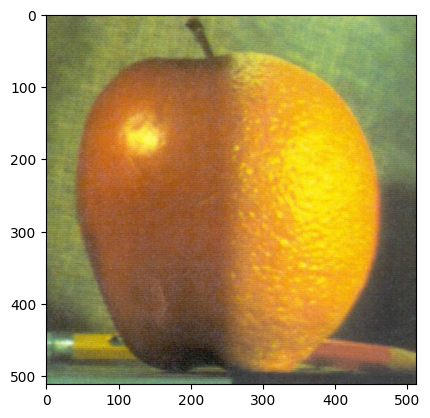

In [10]:
plt.imshow(blended_image)